__________
**Sentiment Analysis on Tweets**

*Author:* Eleonora Misino 

*Date:* March 2021

*Mail:* eleonora.misino@gmail.com
_________

# Introduction
This project is focused on **comparing different text representations** and **learning models** on a classification task.  
We will work on a **large supervised dataset of English tweets** ([Sentiment140 dataset](https://www.kaggle.com/kazanova/sentiment140)), which contains $1.6$ million samples. Since working with the whole dataset would be really time consuming, and would not allow us to compare different models in a reasonable amount of time, we will work on a reduced number of tweets ($320K$).  

We will focus on **3 text representation strategies**:
* *Bag-of-Words* (BoW)
* *TF-IDF* 
* *Word2Vec* (w2v) 

and **3 classifiers**:
* *Multinomial Naive Bayes* (MNB)
* *Logistic Regression* (LogReg)
* *Multi-layer Perceptron* (MLP)

We will fine-tune *BoW, TF-IDF, MNB* and *LogReg* **hyperparameters** through a **grid search** with **5-fold cross validation**, but we will not perform the grid search on *MLP* and *Word2Vec* hyperparameters, since their training time is quite consuming.

Finally, we will statistically compared the accuracy of the best models using a test set of $64K$ pre-processed tweets.

_________________________
**Project workflow**


1.   *Download Data*
2.   *Exploratory Data Analysis*
3.   *Tweets Features Extraction*
4.   *Text Preprocessing*
5.   *Models Training*
6.   *Models Comparison* 


-------------------------------------
__NOTES__  
1. Code cells marked with `# WARNING: time consuming!` require 1 ÷ 10 minutes to be executed depending on your machine.  

2. Code cells marked with `# WARNING: highly time consuming!` require 20 ÷ 120 minutes to be executed depending on your machine. 

3. The output of some code cells has been cleaned to keep the notebook as compact as possible. Thus, **any relevant output/image can be found in the corresponding markdown cell**.

_______________________


# Configuration

In [ ]:
!pip install gensim --upgrade
!pip install emoji --upgrade
!pip install -q kaggle
!pip install contractions

In [ ]:
##########
# IMPORT #
##########

# Utility
from collections import Counter
import emoji
import itertools
import json
import logging
import numpy as np
import os
import pandas as pd
import random
import re
import string
import time

# Matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)
%matplotlib inline

# Nltk
from nltk import download
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
download('stopwords')
STOPWORDS = stopwords.words("english")

# Sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import accuracy_score, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

# Scipy 
import scipy.stats as st

# Word2vec
import gensim

# Word Cloud
from wordcloud import WordCloud

# Contraction
import contractions

#####################
#  REPRODUCIBILITY  #
#####################

# Seed value
SEED_VALUE= 42
os.environ['PYTHONHASHSEED']=str(SEED_VALUE)
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Download Data
As already mentioned in the *Introduction*, we work on a fraction of [Sentiment140 dataset](https://www.kaggle.com/kazanova/sentiment140), which contains $1.6$ million English tweets.  
To download the dataset directly from Kaggle we need to access Kaggle API using a private API token (more info [here](https://github.com/Kaggle/kaggle-api#api-credentials)).

In [ ]:
# Kaggle API token
USER_ID = 'elemisi' # REPLACE WITH YOUR OWN USER NAME
USER_SECRET = 'e4eea8aec8314ea7ba117fc4b6d56518' # REPLACE WITH YOUR OWN PRIVATE API TOKEN
KAGGLE_CONFIG_DIR = os.path.join(os.path.expandvars('$HOME'), '.kaggle')

# Create the required json file
os.makedirs(KAGGLE_CONFIG_DIR, exist_ok = True)
with open(os.path.join(KAGGLE_CONFIG_DIR, 'kaggle.json'), 'w') as f:
    json.dump({'username': USER_ID, 'key': USER_SECRET}, f)


In [ ]:
!chmod 600 {KAGGLE_CONFIG_DIR}/kaggle.json
!kaggle datasets download -d kazanova/sentiment140
!mkdir data
!unzip sentiment140.zip -d data

We read data from the unzipped csv file by relying on `pandas` library:

In [ ]:
DATASET_COLUMNS = ["sentiment", "id", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"

dataset_filename = os.listdir("data")[0]
dataset_path = os.path.join("data", dataset_filename)
df = pd.read_csv(dataset_path, encoding=DATASET_ENCODING , names=DATASET_COLUMNS)

# Exploratory Data Analysis




The dataset contains 6 columns:

* `sentiment`: the polarity of the tweet encoded with an integer value ($0 : negative$, $2: neutral$, $4:positive$).
* `id`:
* `date`: tweet timestamp
* `flag`: query applied to collect the tweet (if any)
* `user`: tweet author
* `text`: tweet text

By looking at the outputs below, we can easily conclude that
* the dataset is **well-formed**: no missing value or NaN;
* no queries have been applied to collect the tweets, as specified in the dataset description;
* **there are only two sentiments**: $positive$ and $negative$;
* there are very few tweet duplicates (1685 out of 1.6 million).




In [ ]:
df.head()

,sentiment,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  int64 
 1   id         1600000 non-null  int64 
 2   date       1600000 non-null  object
 3   flag       1600000 non-null  object
 4   user       1600000 non-null  object
 5   text       1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [ ]:
# Unique values per column
for feature in df.columns.tolist():
  print("{} unique values -> {}".format(feature, len(df[feature].unique()))) 

sentiment unique values -> 2
id unique values -> 1598315
date unique values -> 774363
flag unique values -> 1
user unique values -> 659775
text unique values -> 1581466


In [ ]:
# No queries have been applied
df.flag.unique()

array(['NO_QUERY'], dtype=object)

In [ ]:
# There are only two sentiments
df.sentiment.unique()

array([0, 4])

In [ ]:
# There are some duplicates
df[df.duplicated(subset='id', keep="first")]

## Remove unuseful features

`flag`, `date`, `id` and `user` does not bring any additional information to our purpose.
Thus, we simply **remove these columns** from the dataframe:

In [ ]:
df.pop('flag')
df.pop('date')
df.pop('id')
df.pop('user')

## Dataset Balancing 
Let's **decode the integer labels** into the corresponding sentiments and **check whether our dataset is balanced or not**.

In [ ]:
def decode_sentiment(label, sentiment_dict):
    """Decodes the integer labels into the corresponding sentiments."""
    return sentiment_dict[int(label)]

In [ ]:
sentiment_dict = {0: "NEGATIVE",  
                  4: "POSITIVE"}

# Decoding
df.sentiment = df.sentiment.apply(lambda x: decode_sentiment(x,sentiment_dict ))
# Counting 
sentiment_cnt = Counter(df.sentiment)

As we can see in the figure below, our dataset is **perfectly balanced**:

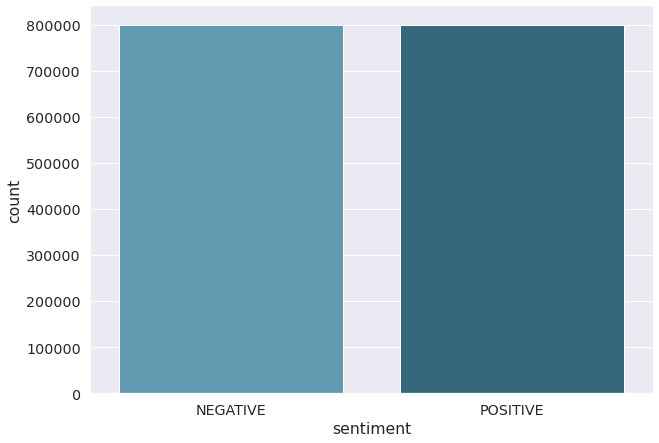

In [ ]:
sns.catplot(x="sentiment", data=df, kind="count", height=6, aspect=1.5, palette="PuBuGn_d")
plt.show();

## Working with a reduced dataframe
As already described in the *Introduction*, *Sentiment140* dataset contains 1.6 million tweets, which is a relevant amount of data. Working with the whole dataset would be really time consuming and would not allow us to compare different models in a reasonable amount of time.   
Since the aim of this project is to compare different classification models and text representations, we decided to **reduce the dataset** and work with only $320K$ tweets ($160K$ for each of the two sentiments).  

____________________
__NOTE__ : do not run this section if you prefer to work with the whole dataset.
_________

In [ ]:
positive_df, _ = train_test_split(df[df.sentiment == "POSITIVE"], 
                                         test_size=0.80, 
                                         train_size=0.20, 
                                         random_state=SEED_VALUE,
                                         shuffle=False, 
                                         stratify=None)

negative_df, _ = train_test_split(df[df.sentiment == "NEGATIVE"], 
                                         test_size=0.80, 
                                         train_size=0.20, 
                                         random_state=SEED_VALUE,
                                         shuffle=False, 
                                         stratify=None)

In [ ]:
# Concatenate positive and negative samples
df = pd.concat([positive_df, negative_df], ignore_index=True)
# Shuffle and reset index
df = df.sample(frac=1, random_state=SEED_VALUE).reset_index(drop=True)

In [ ]:
df.describe()

,sentiment,text
count,320000,320000
unique,2,316993
top,NEGATIVE,"cant afford to see Angels and Demons, so i wa..."
freq,160000,86


## Word Cloud
Before focusing our attention on the extraction of some tweet features, it could be interesting to have a look at positive and negative tweets using a *Word Cloud*, a **visual representation** commonly used in text exploration.  
In a word cloud each word is shown with a font size proportional to its frequency, i.e. **bigger term means higher frequency**. Thus, *Word Cloud* can be very useful to quick perceive the most prominent terms in a text.

In the figure below, we display the word cloud of negative tweets (*on the left*) and positive tweets (*on the right*).

<img src= 'https://drive.google.com/uc?id=11wFJYp6r85VvrUszmrKcgo7RNznpxRPX'>


As we can see in the figure above:

* in **positive word cloud** we can read terms like _**good, love, thank**_, and also __*lol, great, happy, fun*__.   
* Conversely, in the **negative word cloud** we read words like __*work, back, bad*__, and also __*miss, hate, sorry, sad, tired*__.  
* **Some very frequent terms** such as *day, now, going* **are in common**,   since thay can be used in both the contexts.

By **removing** `nltk` list of **stopwords** plus term *day*, we can see some interesting features springing up:

<img src= 'https://drive.google.com/uc?id=1zxdynLJUVxfvFOm2petVMykRCkTcvhuD'>

* The high frequency of __*I'm*__ in both the word clouds may underline the self-centered nature of tweets content.
* The relevance of __*http*__ and __*com*__ in the positive word cloud may suggest that **positive tweets have a higher number of external links** in their texts with respect to negative one: this could be an interesting feature to explore more (see next section).






In [ ]:
# Building positive and negative corpus
positive_corpus = positive_df["text"].tolist()
negative_corpus = negative_df["text"].tolist()

In [ ]:
%%time
# Creating Word Cloud
wordcloud_NEG = WordCloud(width = 3000, 
                          height = 2000, 
                          collocations=False, 
                          random_state = SEED_VALUE,
                          stopwords = STOPWORDS + ['day'], # set to None to get the raw text word cloud
                          colormap = 'gist_rainbow').generate(" ".join(negative_corpus))
wordcloud_POS = WordCloud(width = 3000, 
                          height = 2000, 
                          collocations=False, 
                          random_state = SEED_VALUE,
                          stopwords = STOPWORDS + ['day'], # set to None to get the raw text word cloud
                          colormap = 'gist_rainbow').generate(" ".join(positive_corpus))

In [ ]:
# Plot
_, ax = plt.subplots(1, 2, figsize=(20,20))
ax[0].axis("off")
ax[0].imshow(wordcloud_NEG) 
ax[0].set_title('Negative Tweets')
ax[1].axis("off")
ax[1].imshow(wordcloud_POS) 
ax[1].set_title('Positive Tweets')
plt.show()

# Tweet Features Extraction
As we have seen in the previous section, our tweets corpus may contain some hidden information - like the number of links - that can be used as additional features in the classification process.  
Here is the list of features we are going to extract from each tweet:

*  **number of words** (`n_words`)
*  **number of uppercase words**, frequently used to "shout" (`n_capitals`)
*  **number of question or exclamation marks** (`n_qe_marks`)
*  **number of hashtags** (`n_hashtags`)
*  **number of mentions** to other Twitter accounts (`n_mentions`)
*  **number of links** (`n_urls`)
*  **number of emoji** (`n_emoji`)

To extract these features we rely on regular expressions:
*  **number of words** $\rightarrow$ counting all words (`\w+`)
*  **number of uppercase words** $\rightarrow$ counting all uppercase words of 2 or more letters`\b[A-Z]{2,}\b`)
*  **number of question or exclamation marks** $\rightarrow$ counting all question and exclamation marks (`!|\?`)
*  **number of hashtags** $\rightarrow$ counting all words preceded by  `#` (`#\w+`)
*  **number of mentions** $\rightarrow$ counting all words preceded by  `@` (`@\w+`)
*  **number of links** $\rightarrow$ counting all the sequences starting with `http` and containing `:\\` (`http.?:\/\/[^\s]+[\s]?`)
*  **number of emoji** $\rightarrow$ counting all the sequences of letters and `&` or `_` delimited by `__` (`_+[a-z_&]+_+`)
__________________
__NOTE__  
Regarding `n_emoji`, before counting the regex matching, we pick each emoji and transform it into the corresponding string using the `demojize` function of module `emoji` with `delimiters` paramter set to `(__,__)`. Thus, for example: 
* `"👍"` $\rightarrow$ `"__thumbs_up__"`
* `"😯"` $\rightarrow$ `"__hushed_face__"`

____________

In [ ]:
class TextFeaturesCount(BaseEstimator, TransformerMixin):
    """
    Class designed to extract text features from raw tweets (see above for more details).
    """
    
    def count_regex(self, pattern, tweet, case_sensitive = True):
        """ Returns the number of correspondences of the given regex."""
        if case_sensitive:
           return len(re.findall(pattern, tweet))
        else:
          return len(re.findall(pattern, tweet, re.IGNORECASE))
    
    def fit(self, X, y=None, **fit_params):

        return self
    
    def transform(self, X, **transform_params):
        
        n_words = X.apply(lambda x: self.count_regex(r'\w+', x)) 
        n_capitals = X.apply(lambda x: self.count_regex(r'\b[A-Z]{2,}\b', x))
        n_qe_marks = X.apply(lambda x: self.count_regex(r'!|\?', x))
        n_hashtags = X.apply(lambda x: self.count_regex(r'#\w+', x))
        n_mentions = X.apply(lambda x: self.count_regex(r'@\w+', x))
        n_urls = X.apply(lambda x: self.count_regex(r'http.?:\/\/[^\s]+[\s]?', x))
        n_emoji = X.apply(lambda x: emoji.demojize(x, delimiters=("__", "__")))\
                   .apply(lambda x: self.count_regex(r'_+[a-z_&]+_+', x))
        
        df = pd.DataFrame({  'n_words': n_words
                           , 'n_mentions': n_mentions
                           , 'n_hashtags': n_hashtags
                           , 'n_capitals': n_capitals
                           , 'n_qe_marks': n_qe_marks
                           , 'n_urls': n_urls
                           , 'n_emoji': n_emoji
                          })
        
        return df


In [ ]:
# Example
sample_text = pd.Series({"QE MARKS and EMOJI":"Test qe marks and emoji!?! 😯",
                         "HASHTAG and MENTIONS":"#testHashtag, @testMention",
                         "LINKS and CAPITALS":"https://www.prova.com, TEST CAPITALS"})
tc = TextFeaturesCount()
test_features = tc.fit_transform(sample_text)
test_features

,n_words,n_mentions,n_hashtags,n_capitals,n_qe_marks,n_urls,n_emoji
QE MARKS and EMOJI,5,0,0,0,3,0,1
HASHTAG and MENTIONS,2,1,1,0,0,0,0
LINKS and CAPITALS,6,0,0,2,0,1,0


In [ ]:
# WARNING: time consuming!
%%time

tc = TextFeaturesCount()
df_features = tc.fit_transform(df.text)
df_features['sentiment'] = df.sentiment

In the cell below we display the distribution of the extracted features with respect to the corresponding tweet sentiment.  
As we can clearly see from the data:
* we do not have long texts, as expected from the nature of our dataset;
* potitive tweets seem to contain more mentions than negative tweets;
* the vast majority of tweets does not contain hashtags, question/exclamation marks, external links or emoji;



-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

 n_words
-------------------
              count       mean       std  min  25%   50%   75%   max
sentiment                                                           
NEGATIVE   160000.0  14.179806  7.402060  1.0  8.0  13.0  20.0  54.0
POSITIVE   160000.0  13.477781  7.151958  1.0  8.0  12.0  19.0  56.0



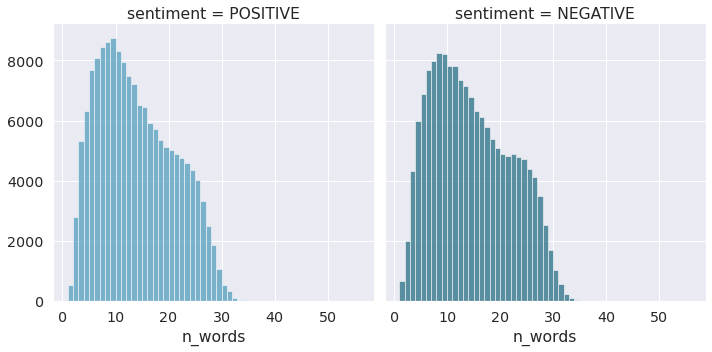


-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

 n_mentions
----------------------
              count      mean       std  min  25%  50%  75%   max
sentiment                                                        
NEGATIVE   160000.0  0.373606  0.525786  0.0  0.0  0.0  1.0   9.0
POSITIVE   160000.0  0.576531  0.588192  0.0  0.0  1.0  1.0  12.0



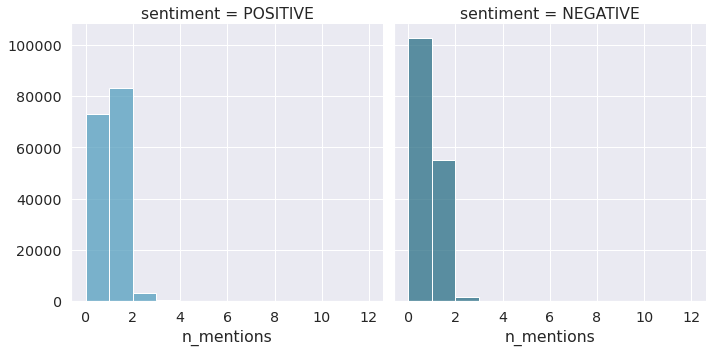


-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

 n_hashtags
----------------------
              count      mean       std  min  25%  50%  75%   max
sentiment                                                        
NEGATIVE   160000.0  0.019656  0.176161  0.0  0.0  0.0  0.0  10.0
POSITIVE   160000.0  0.025831  0.215149  0.0  0.0  0.0  0.0  11.0



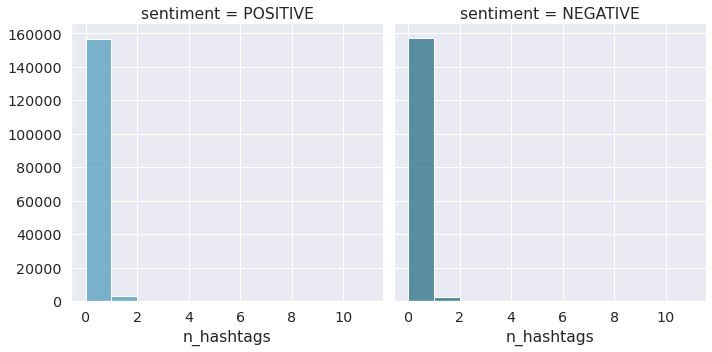


-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

 n_capitals
----------------------
              count      mean       std  min  25%  50%  75%   max
sentiment                                                        
NEGATIVE   160000.0  0.244944  1.044505  0.0  0.0  0.0  0.0  27.0
POSITIVE   160000.0  0.253350  0.980622  0.0  0.0  0.0  0.0  28.0



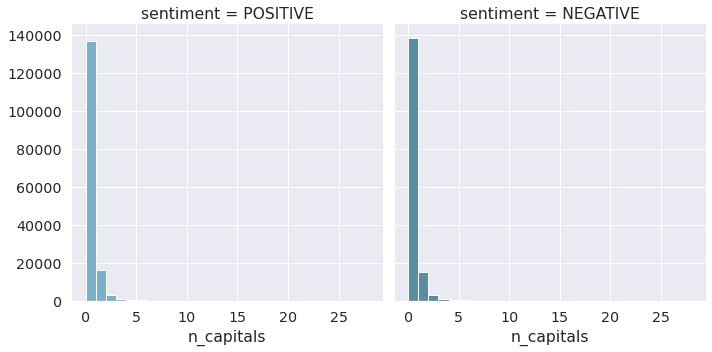


-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

 n_qe_marks
----------------------
              count      mean       std  min  25%  50%  75%    max
sentiment                                                         
NEGATIVE   160000.0  0.616175  1.585735  0.0  0.0  0.0  1.0  111.0
POSITIVE   160000.0  0.795462  1.590917  0.0  0.0  0.0  1.0  105.0



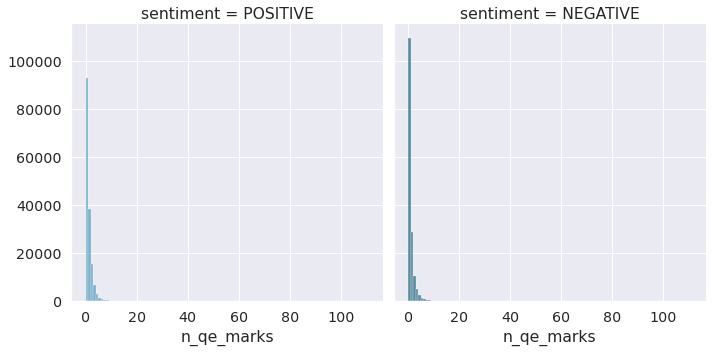


-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

 n_urls
------------------
              count      mean       std  min  25%  50%  75%  max
sentiment                                                       
NEGATIVE   160000.0  0.029013  0.171452  0.0  0.0  0.0  0.0  3.0
POSITIVE   160000.0  0.058506  0.239653  0.0  0.0  0.0  0.0  4.0



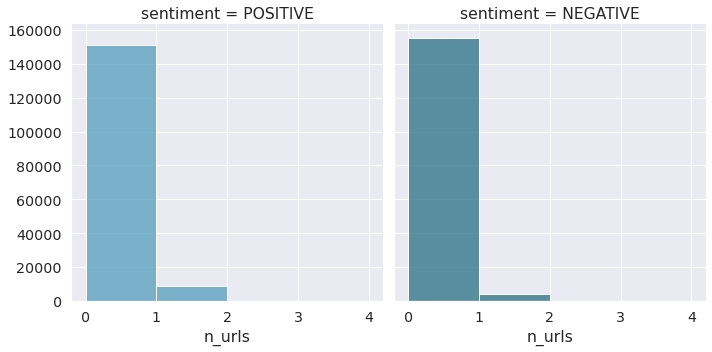


-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

 n_emoji
-------------------
              count      mean       std  min  25%  50%  75%  max
sentiment                                                       
NEGATIVE   160000.0  0.002537  0.051172  0.0  0.0  0.0  0.0  3.0
POSITIVE   160000.0  0.003687  0.061024  0.0  0.0  0.0  0.0  3.0



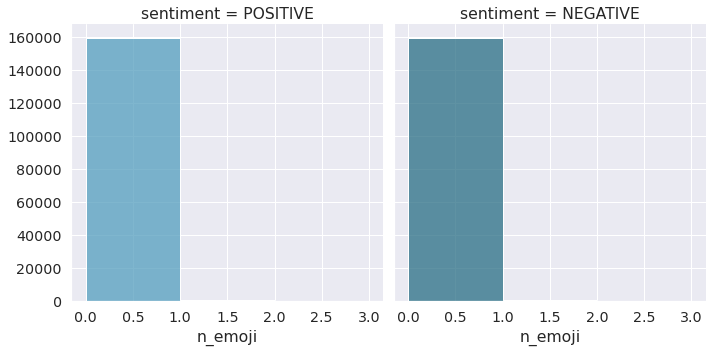

In [ ]:
for col in df_features.columns.to_list()[:7]:
    # Statistics
    print()
    print('-*'*(len(col)+40))
    print('\n {}'.format(col))
    print('-'*(len(col)+12))
    print(df_features.groupby('sentiment')[col].describe())
    print()
    
    # Plot
    bins = np.arange(df_features[col].min(), df_features[col].max() + 1)
    g = sns.FacetGrid(df_features, col='sentiment', height=5, hue='sentiment', palette="PuBuGn_d")
    g = g.map(sns.histplot, col, kde=False, bins=bins)
    plt.show()

## Hypothesis Test

Since our data set is considerably large, we can perform a **two sample Z-test with $\alpha = 1\%$** on each tweet feature to verify whether the difference between the mean of the two populations (`POSITIVE` and `NEGATIVE` tweets) is statistically significant.   
If a feature passes the test, than we keep it as a new feature for our classification task, otherwise we discard it.





In [ ]:
def twoSample_Ztest(mu1, mu2, sigma1, sigma2, n1, n2, alpha = 0.05):
    """ 
    Two sample Z-test.

    Parameters
    ----------
    - mu1, sigma1 [float]: mean and standard deviation of the first population.
    - mu2, sigma2 [float]: mean and standard deviation of the second population. 
    - n1, n2 [int]: population sizes
    - alpha [float]: alpha level [default 0.05]
    """

    ovr_sigma = np.sqrt(sigma1**2/n1 + sigma2**2/n2)
    z = (mu1 - mu2)/ovr_sigma
    p_val = 2*(1 - st.norm.cdf(abs(z)))
    print("Confidence: {:.1%}".format(1-alpha))
    if (p_val < alpha):
      print('p-value:', round(p_val,5), '\nThe difference between the mean of the two populations is \033[1mstatistically significant.\033[0m')
    else:
      print('p-value:', round(p_val,5), '\nThe difference between the mean of the two populations is \033[1m NOT statistically significant.\033[0m')

In [ ]:
for col in df_features.columns.to_list()[:7]:

  print('\nHYPOTHESIS TEST ON {}'.format(col))
  print('-'*(len(col)+22))

  mu_pos = df_features.groupby('sentiment')[col].mean().loc["POSITIVE"]
  mu_neg = df_features.groupby('sentiment')[col].mean().loc["NEGATIVE"]
  sigma_pos = df_features.groupby('sentiment')[col].std().loc["POSITIVE"]
  sigma_neg = df_features.groupby('sentiment')[col].std().loc["NEGATIVE"]
  n_pos = Counter(df.sentiment)["POSITIVE"]
  n_neg = Counter(df.sentiment)["NEGATIVE"]
  twoSample_Ztest(mu_pos, mu_neg, sigma_pos, sigma_neg, n_pos, n_neg, alpha = 0.01)



HYPOTHESIS TEST ON n_words
-----------------------------
Confidence: 99.0%
p-value: 0.0 
The difference between the mean of the two populations is statistically significant.

HYPOTHESIS TEST ON n_mentions
--------------------------------
Confidence: 99.0%
p-value: 0.0 
The difference between the mean of the two populations is statistically significant.

HYPOTHESIS TEST ON n_hashtags
--------------------------------
Confidence: 99.0%
p-value: 0.0 
The difference between the mean of the two populations is statistically significant.

HYPOTHESIS TEST ON n_capitals
--------------------------------
Confidence: 99.0%
p-value: 0.01893 
The difference between the mean of the two populations is  NOT statistically significant.

HYPOTHESIS TEST ON n_qe_marks
--------------------------------
Confidence: 99.0%
p-value: 0.0 
The difference between the mean of the two populations is statistically significant.

HYPOTHESIS TEST ON n_urls
----------------------------
Confidence: 99.0%
p-value: 0.0 
The 

According to the results shown above, we can consider **all tested features except for `n_capitals` statistically significant** with $99\%$ of confidence. Thus, we proceed by removing `n_capitals` and keeping all the remaining features:

In [ ]:
df_features.pop('n_capitals')
FEATURES_LIST = df_features.columns.tolist()[:-1]

# Text Preprocessing
The tweets we are going to work with are an example of **unstructured text data** that needs to be **preprocessed** in order to be properly used in the classification task.  
In the cells below we define and apply the following sequence of operations on each tweet in the dataset:

1. *Mentions Removal*
2. *URLS Removal*
4. *Digits Removal*
6. *Lowercase*
7. *Expand Contractions*
5. *Punctuation Removal*
3. *Emoji Transformation*
8. *Stopwords removal* or *Short terms filtering* 
9. *Stemming*


Some of these steps deserve a closer look:

**5. Expand Contractions**  
We rely on `contractions` library to expand English contractions such as 'you're' $\rightarrow$ 'you are', 'they won't' $\rightarrow$ 'they will not', and so on. 

**7. Emoji Transformation**  
As already described in *Tweet Features Extraction*, we pick each emoji and transform it in the corresponding string using the `demojize` function of module `emoji`. For example: 
* `"👍"` $\rightarrow$ `"::thumbs_up::"`
* `"😯"` $\rightarrow$ `"::hushed_face::"`

Then, we remove `:` and keep `_` in order to have one single word for each emoji.

**8. Stopwords removal or Short terms filtering**  
We test two different pre-processing strategies:
  * **Remove English stopwords**: we use `ntlk` list of English stopwords to prune out words which are usually not really informative (articles, auxiliary verbs, conjunctions, etc.). The effectiveness and correctness of this widely used strategy strictly depend on the dataset characterstics.
  * **Filter out very short terms**: we discovered that our corpus is plenty of short and meaningless terms composed by 1 or 2 letters (see the *note* below). Thus, instead of removing stopwords, we filter out terms shorter than 3 letters or contained in a customized list of very frequent and not highly meaningful terms (see the *note* below). By doing so we are able to filter out typos, articles and prepositions without loosing terms which may be meaningful in our application.



**9. Stemming**  
As stemmer we use **Snowball**, a class of stemmer algorithms developed by Martin Porter (more info [here](https://snowballstem.org/)). We rely on `nltk.stem.snowball` implementation to efficiently use this algorithms in our process.

______
*NOTE*

* List of terms with 1 or 2 characters contained in our corpus: 
> [ya
n
co
go
us
ew
wa
g
f
oh
x
w
ad
im
ur
hi
lt
eh
jo
th
pm
gt
xo
b
tv
p
ok
u
ro
po
nd
em
er
ke
rd
bq
ch
l
ng
et
um
yo
bz
la
ho
az
fb
sf
ps
uh
r
c
bb
dm
pp
xx
pa
kp
mg
pe
ah
da
jt
st
z
aw
xd
nk
mr
fo
ac
vs
dl
np
ha
dn
hv
sd
ks
v
hr
h
le
cl
rt
bf
pt
de
en
ty
hp
hd
ap
e
fr
nz
yt
kk
ow
mb
ex
hw
fe
te
pc
dr
jb
jj
k
ko
sa
yr
sc
ss
fs
ms
ne
wu
cd
na
cs
nh
ph
nt
un
fm
cx
ep
xp
mi
ni
al
fn
gp
j
ed
bo
bs
ny
lj
dj
mm
dd
iv
nb
od
kj
wz
sw
hs
gm
ct
bt
dw
mu
uk
ts
df
id
yu
ef
cj
lv
wk
ee
ab
tc
es
ud
uw
jk
mo
jc
gb
mz
li
hm
ft
il
si
rb
cu
cp
ka
oz
nw
lo
mp
rs
va
bg
os
tm
gh
ov
md
pb
js
ds
rm
ot
vh
ba
gd
dg
wp
ae
bi
br
ui
au
jz
hn
cm
hl
pr
pi
cv
ga
op
rp
sn
vk
ub
gf
ii
ff
sh
lg
cf
mj
ye
hk
ip
fc
yk
rv
kg
se
wb
bc
ou
up
dc
mk
oc
nj
tn
ly
ez
ol
tx
ta
ax
oe
io
cg
kc
xi
ie
gi
ak
tj
mt
av
vi
bp
vv
ju
bm
fi
dx
bh
nc
vb
ik
wt
rc
ox
pw
ob
oj
wi
jd
ut
fw
bn
eu
gr
sg
ib
kl
tt
lm
kt
hy
wd
ea
tu
qu
wh
q
fg
yw
bk
fx
pl
zi
bd
km
ra
om
vu
iq
el
tf
hq
lc
cw
ck
eb
oy
wf
mw
ai
sq
kb
tb
rx
su
ja
dh
oi
gs
ze
gg
ey
fa
nl
mc
ky
sv
xy
oo
eg
ev
hb
ku
di
qs
nv
af
eo
ia
qt
fl
pj
zq
rn
wn
tp
rg
ag
sb
jp
vp
fu
du
cc
ca
wc
fy
bu
iz
vt
aj
gc
sy
aa
ml
nm
ld
ws
fp
ki
sx
jm
je
jr
gz
qq
td
sm
xc
ec
dt
lr
ay
xl
ym
sl
pg
ar
qi
ls
mv
hc
cn
lp
lk
rj
pd
mx
db
jg
bx
zz
vn
hu
tz
gl
ry
xs
cr
kf
vo
sj
dy
ua
ce
nu
sp
an
ti
iu
yi
ht
lx
ao
ci
ek
wo
tr
cy
uy
ww
yg
yh
a
ri
ih
dp
in
pu
uu
jw
kh
lb
tk
dk
or
rl
mn
ns
lu
ru
sr
uc
xa
xt
bj
og
ge
rr
cb
vw
vy
ux
tw
gk
kw
vm
rh
am
gn
uz
ue
gv
zu
ir
uv
lh
on
sk
rz
at
gw
tg
ul
if
ic
yn
px
bw
kd
xb
nr
hg
kv
ei
bl
dq
pf
mh
pq
jl
za
aq
py
zf
zs
rw
dz
wm
jv
ys
oa
lw
qe
wl
hj
qa
ij
tl
ji
of
qc
ln
pv
i
jf
fk
fv
pk
qo
mf
nx
tq
xk
o
wv
hh
kn
be
dv
xm
gj
wy
rk
kr
bv
rf
cz
¿½
zo
zb
ej
uf
fd
iw
qd
yp
ix
vf
vc
ug
gu]

* Here is the customized list of terms used in **Filter out very short terms**. We defined this list by looking at the most frequent terms which are present in both positive and negative word clouds.  
> ['and', 'for', 'that', 'but', 'the', 'you', 'have', 'she', 'they', 'just', 'not']  
_NB: even though there may be more suitable and refined strategies to define this list, their exploration is out of the project scope._

___________

In [ ]:
class CleanText(BaseEstimator, TransformerMixin):
    """
    Class designed to preprocess raw tweets (see above for more details).
    """

    # DIGITS
    def remove_digits(self, input_text):
        """Removes any digits from the text."""
        return re.sub(r'\d+', '', input_text)
    
    # MENTIONS
    def remove_mentions(self, input_text):
        """Removes mentions from the text by finding them through @""" 
        return re.sub(r'@\w+', ' ', input_text)

    # PUNCTUATION
    def remove_punctuation(self, input_text):
        """Replaces any punctuation symbol by a space."""
        punct = string.punctuation + '…“”￼＆—●'
        trantab = str.maketrans(punct, len(punct)*' ')
        return input_text.translate(trantab) 
    
    # STOPWORDS
    def remove_stopwords(self, input_text):
        """Removes english stopwords"""
        words = input_text.split() 
        clean_words = [word for word in words if word not in STOPWORDS] 
        return " ".join(clean_words) 

    # SHORTWORDS
    def remove_shortwords(self, input_text):
        """Removes words of 1 or 2 letters only."""
        words = input_text.split() 
        customized_stopwords = ['and', 
                                'for', 
                                'that', 
                                'but', 
                                'the', 
                                'you', 
                                'have', 
                                'she', 
                                'they', 
                                'just', 
                                'not']
        clean_words = [word for word in words if (len(word) > 2) and not (word in customized_stopwords)]
        return " ".join(clean_words) 
    
    # URLS
    def remove_urls(self, input_text):
        """Removes external links from the text by finding them through http(s)""" 
        return re.sub(r'http.?://[^\s]+[\s]?', ' ', input_text)
    
    # STEMMING
    def stemming(self, input_text):
        """ Returns the input text stemmed using Snowball algorithms."""
        stemmer = SnowballStemmer(language="english")
        words = input_text.split() 
        stemmed_words = [stemmer.stem(word) for word in words]
        return " ".join(stemmed_words)
    
    # EMOJI
    def tranform_emoji(self, input_text):
        """ Transforms emoji in the corresponding word."""
        clean_text = emoji.demojize(input_text, delimiters=("::", "::"))
        return clean_text.replace('::',' ')

    # LOWER
    def to_lower(self, input_text):
        return input_text.lower()

    # CONTRACTIONS
    def expand_contractions(self, input_text):
      return contractions.fix(input_text)


    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, mode = 'shortwords', **transform_params):
        """
        Applies the specified preprocessing pipeline on the input text.
        """
        if mode == 'stopwords':
           clean_X = X.apply(self.remove_mentions)\
                      .apply(self.remove_urls)\
                      .apply(self.remove_digits)\
                      .apply(self.to_lower)\
                      .apply(self.expand_contractions)\
                      .apply(self.remove_punctuation)\
                      .apply(self.tranform_emoji)\
                      .apply(self.remove_stopwords)\
                      .apply(self.stemming)


        elif mode == 'shortwords':
           clean_X = X.apply(self.remove_mentions)\
                      .apply(self.remove_urls)\
                      .apply(self.remove_digits)\
                      .apply(self.to_lower)\
                      .apply(self.expand_contractions)\
                      .apply(self.remove_punctuation)\
                      .apply(self.tranform_emoji)\
                      .apply(self.remove_shortwords)\
                      .apply(self.stemming)


        return clean_X

In [ ]:
# Example
sample_text = pd.Series({"QE MARKS and EMOJI":"Test qe marks and emoji!?! 😯",
                         "HASHTAG and MENTIONS":"#testHashtag, @testMention",
                         "LINKS and CAPITALS":"https://www.prova.com, TEST CAPITALS",
                         "CONTRACTIONS and SHORT TERMS":"ii aa uu kids won't play"})
ct = CleanText()
test_preproc = ct.fit_transform(sample_text)
test_preproc

QE MARKS and EMOJI              test mark emoji hushed_fac
HASHTAG and MENTIONS                           testhashtag
LINKS and CAPITALS                              test capit
CONTRACTIONS and SHORT TERMS                 kid will play
dtype: object

In [ ]:
# WARNING: time consuming!
%%time 
ct = CleanText()
transformer = ct.fit(df.text)
df['shortwords'] = transformer.transform(df.text, mode = 'shortwords')
df['stopwords'] = transformer.transform(df.text, mode = 'stopwords')

In [ ]:
# Preprocessed dataset
df[['text', 'shortwords', 'stopwords']]

,text,shortwords,stopwords
0,Going to get dinner with the parents,go get dinner with parent,go get dinner parent
1,"@wanjagi If I tell you why, you'll regret why ...",tell whi will regret whi ask whi then will sta...,tell regret ask start ask ask
2,hungry for sushi,hungri sushi,hungri sushi
3,Hanging out tonight with the Orr's reminded me...,hang out tonight with orr remind how much go m...,hang tonight orr remind much go miss move
4,@bsmrocks no i'll be atp... get your ass to l...,will atp get your ass london some time soon,i atp get ass london time soon
...,...,...,...
319995,@camen_marris I know. I'll have to get some soon,know will get some soon,know i get soon
319996,I was three minutes late,was three minut late,three minut late
319997,@ashlili LIKE MEEEEEEEEE,like meeeeeeeee,like meeeeeeeee
319998,@chyeahitsalicia I do like Kristen Pattinson Y...,like kristen pattinson btw friend name kristen...,like kristen pattinson hy btw friend name kris...


## Word Cloud 
Let's compare the word clouds before and after text pre-processing.


**Before preprocessing:**

<img src= 'https://drive.google.com/uc?id=1zxdynLJUVxfvFOm2petVMykRCkTcvhuD'> 

**After preprocessing with stopwords removal:**  

<img src= 'https://drive.google.com/uc?id=1LLrrIdXfIN19kwypF1Kna9FmdMNTz4l7'> 


**After preprocessing with short terms filtering:**

<img src= 'https://drive.google.com/uc?id=18NMxDdIYDMAZsTGyC4lGZ6_2bcZGTfy8'> 

With both the preprocessing strategies, the result reflects our expectation:

* contract forms like __*I'm*__ or __*can't*__ have been removed.
* Some verbs became more frequent by stemming the text (e.g. __*go, get, work, ...*__ ).
* __*http*__ and __*com*__ are not present in cleaned text thanks to urls removal step.

After cleaning with **stopwords removal**, the top 4 most frequent words excluding *day* in the Word Cloud are:
* **go, work, get, want** in negative tweets
* **go, good, love, thank** in positive tweets

While with **short terms filtering** we have:
* **was, work, can, get, now, with** in negative tweets
* **are, with, good, thank, love** in positive tweets

With *short terms filtering* we discover a quite interesting **difference in tenses** between negative and positive tweets: in fact, the most frequent word in negative cloud is "was", while in positive cloud we have "are". Since in both corpora, the term "am" has been removed, we cannot claim that negative tweets are more self-centered than positive ones; however, we can conclude that in **negative tweets** the content is more likely in **past tense**.


In [ ]:
# Replace stopwords <-> shortwords for the corresponding Word Cloud
clean_negative_corpus = df[df.sentiment == "NEGATIVE"].shortwords.tolist() 
clean_positive_corpus = df[df.sentiment == "POSITIVE"].shortwords.tolist()

In [ ]:
%%time
# Creating Word Cloud
wordcloud_NEG_CLEANED = WordCloud(width = 3000, 
                                  height = 2000, 
                                  collocations=False, 
                                  stopwords = ['day'],
                                  random_state = SEED_VALUE,
                                  colormap = 'gist_rainbow').generate(" ".join(clean_negative_corpus))
wordcloud_POS_CLEANED = WordCloud(width = 3000, 
                                  height = 2000, 
                                  collocations=False,
                                  stopwords = ['day'],
                                  random_state = SEED_VALUE,
                                  colormap = 'gist_rainbow').generate(" ".join(clean_positive_corpus))


In [ ]:
# Plot
_, ax = plt.subplots(1, 2, figsize=(20,20))
ax[0].axis("off")
ax[0].imshow(wordcloud_NEG_CLEANED) 
ax[0].set_title('Negative Tweets')
ax[1].axis("off")
ax[1].imshow(wordcloud_POS_CLEANED) 
ax[1].set_title('Positive Tweets')
plt.show()


# Models Training
As already anticipated in the *Introduction*, we will the following text representations and classifiers on our pre-processed data set:
* **Text representation strategies**
  * *Bag-of-Words* (BoW)
  * *TF-IDF* 
  * *Word2Vec* (w2v) 

* **Classifiers**
  * *Multinomial Naive Bayes* (MNB)
  * *Logistic Regression* (LogReg)
  * *Multi-layer Perceptron* (MLP)

For BoW, TF-IDF, MNB and LogReg we will perform a **grid search** with **5-fold cross validation** using model **accuracy as scoring**.  
Here are the tested hyperparameters:
* Vectorizer (*BoW* and *TF-IDF*):
  * `max_df` $\in \{0.25, 0.5, 0.75\}$  
    When building the vocabulary the model ignores terms that have a document frequency strictly higher than `max_df`. Thus, we are applying a **corpus-specific stop words removal**.
  * `min_df` $\in \{1, 2\}$  
  When building the vocabulary the model ignores terms that have a document frequency strictly lower than `min_df` (**cut-off**).
  * `ngram_range`$\in \{(1,1), (1,2)\}$  
  The lower and upper boundary of each `ngram_range` specify the n-grams to be extracted.
  
* *MNB*
  * `alpha` $\in \{0.25, 0.5, 0.75\}$  
  __Additive smoothing parameter__ (i.e. the small-sample correction that will be incorporated in every probability estimate in order to have no zero probability).
* *LogReg*
  * `C` $\in \{0.5, 0.75, 1.0\}$  
  __Inverse of regularization strength__: smaller values specify stronger regularization.

*Multi-Layer Perceptron* training requires more than 1 hour, thus we will not perform a grid-search on this model.  

We will also explore a dense embedding strategy by training *Word2Vec* model on our corpus.   
Once trained, we will use *Word2Vec* model to **encode each term** of the tweets into the corresponding **300-dimensional embedding vector**. Then, we will compute the **mean among the embedding vectors** to build a sequence of $300$ new features for each tweet.  
Since the resulting mean vector may have **negative components**, we will combine *Word2Vec* only with *LogReg* and *MLP* model (*MNB* assumes the variables to have a multinomial distribution which is not defined for negative values).

We will use $80\%$ of the data to train the above mentioned models, while the remaining $64K$ tweets will be the test set.
_______
**NOTE**  
See the *Appendix* for the results of the above-mentioned tests.
______

## Prepare model input

As first step we merge the tweet features extracted in *Tweet Features Extraction* section with the preprocessed text:

In [ ]:
model_input = df_features
model_input['clean_text'] = df.shortwords # Replace stopwords <-> shortwords as needed
model_input

,n_words,n_mentions,n_hashtags,n_qe_marks,n_urls,n_emoji,sentiment,clean_text
0,7,0,0,0,0,0,POSITIVE,go get dinner with parent
1,23,1,0,0,0,0,NEGATIVE,tell whi will regret whi ask whi then will sta...
2,3,0,0,0,0,0,NEGATIVE,hungri sushi
3,22,2,0,0,0,0,NEGATIVE,hang out tonight with orr remind how much go m...
4,14,1,0,0,0,0,NEGATIVE,will atp get your ass london some time soon
...,...,...,...,...,...,...,...,...
319995,10,1,0,0,0,0,POSITIVE,know will get some soon
319996,5,0,0,0,0,0,NEGATIVE,was three minut late
319997,3,1,0,0,0,0,POSITIVE,like meeeeeeeee
319998,21,1,0,1,0,0,POSITIVE,like kristen pattinson btw friend name kristen...


A side-effect of text pre-processing is that **some tweets may not have any words left after the cleaning**.  Therefore, we proceed by **removing empty text tweets**: 
* 1571 tweets have no words left after text cleaning with **Stopwords Removal**.
* 942 tweets have no words left after text cleaning with **Short terms filtering**.


In [ ]:
n_empty_rows = len(model_input[model_input['clean_text'] == ''])
print('{} tweets have no words left after text cleaning.'.format(n_empty_rows))
model_input = model_input[model_input['clean_text'] != '']

Finally, we split our input data in train and test set ($80\%$ and $20\%$ respectively):

In [ ]:
# Train and test data
X_train, X_test, y_train, y_test = train_test_split(model_input.drop('sentiment', axis=1), 
                                                  model_input.sentiment, 
                                                  test_size=0.2, 
                                                  random_state=SEED_VALUE)

## Grid Search Definition
To define a customized grid search, we rely on [scikit-learn example](http://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html).

In [ ]:
##########################
# Custimized Grid Search #
##########################

def customizedGridSearch(clf, parameters_clf, X_train, y_train, X_test, y_test, parameters_text=None, vect=None, is_w2v=False):
    """
    Performs a 5-fold cross validation grid search on the specified classifier and vectorizer.
    
    Parameters
    ----------
      clf: classifier to be tested

      paramters_clf: list of values for the classifier hyperparameters

      X_train, y_train, X_test, y_test: train and test set 

      parameters_text: list of values for vectorizer hyperparamters

      vect: vectorizer

      is_w2v [bool]: whether we want to work with Word2Vec embedding or not
    """
    
    # Dense Embedding Pipeline
    if is_w2v:
        w2vcols = []
        for i in range(EMBEDDING_DIM):
            w2vcols.append(i)
        features = FeatureUnion([('textcounts', ColumnExtractor(cols=FEATURES_LIST)),('w2v', ColumnExtractor(cols=w2vcols))],
                                n_jobs=-1)
        
    # Sparse Text Representation Pipeline
    else:
        features = FeatureUnion([('textcounts', ColumnExtractor(cols=FEATURES_LIST)),
                                 ('pipe', Pipeline([('cleantext', ColumnExtractor(cols='clean_text')),('vect', vect)]))],
                                 n_jobs=-1)

    
    # Grid Search pipeline
    pipeline = Pipeline([('features', features),('clf', clf)])

    # Grid Search parameters
    parameters = dict()
    if parameters_text:
        parameters.update(parameters_text)
    parameters.update(parameters_clf)
    
    # 5-fold Cross Validation Grid Search
    grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, verbose=1)
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(parameters)
    t0 = time.time()
    grid_search.fit(X_train, y_train)
    print("done in %0.3fs" % (time.time() - t0))
    print()
    # Best Model Result on CV
    print("Best CV score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
    # Best Model Result on Test set
    print("Test score with best_estimator_: %0.3f" % grid_search.best_estimator_.score(X_test, y_test))
    print("\n")
    print("Classification Report Test Data")
    print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))
                        
    return grid_search



class ColumnExtractor(TransformerMixin, BaseEstimator):
    """Class utility to easily extract columns from a dataframe."""

    def __init__(self, cols):
        self.cols = cols

    def transform(self, X, **transform_params):
        return X[self.cols]

    def fit(self, X, y=None, **fit_params):
        return self


In [ ]:
##########################
# Grid Search Parameters #
##########################

# Vectorizers Parameters (Count and TF-IDF)
parameters_vect = {
    'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
    'features__pipe__vect__ngram_range': ((1, 1), (1, 2)),
    'features__pipe__vect__min_df': (1,2)
}

# Multinomial Naive Bayes Parameters
parameters_mnb = {'clf__alpha': (0.25, 0.5, 0.75)}

# Logistic Regression Parameters
parameters_lr = {'clf__C': (1., 0.75, 0.5)}


In [ ]:
# Vectorizers
countVect = CountVectorizer()
tfidfVect = TfidfVectorizer()

# Classifiers
mnb = MultinomialNB()
lr = LogisticRegression()

## Bag-of-Words

*BoW* model is one of the simplest text representation technique: each document is represented as a **$N$-dimensional vector**, where $N$ is the total number of tokens in the whole corpus (a token may be a single word or a single $n$-gram, with $n>2$), and each component corresponds to the occurrence of the corresponding token into the current document. Thus, we end up with a **token-document matrix of counts**.  
This simple model as some **drawbacks**:
* it produces a **sparse representation**, since many words may not appear in a given document (frequency = 0);
* it cannot capture phrases and multi-word expressions, effectively **ignoring** any **word order dependence**.

In the cells below we test *BoW* model combined with *MNB* and *LogReg* (tested parameters are defined and explained in *Model Training*).


### Multinomial Naive Bayes Classifier

In [ ]:
# WARNING: highly time consuming!
# Grid Search
mnb_countVect = customizedGridSearch(mnb, parameters_mnb, X_train, y_train, X_test, y_test, parameters_text=parameters_vect, vect=countVect)

In [ ]:
%%time
# Train the best model configuration
features = FeatureUnion([('pipe', Pipeline([('cleantext', ColumnExtractor(cols='clean_text')),
                                    ('vect', CountVectorizer(max_df=0.25, min_df=2, ngram_range=(1,2)))]))], 
                        n_jobs=-1)

pipeline = Pipeline([('features', features), 
                     ('clf', MultinomialNB(alpha = 0.75))])

clf = pipeline.fit(X_train, y_train)

In [ ]:
# Test the trained model on the test set
print("Accuracy on test set:", accuracy_score(y_test, clf.predict(X_test)))
print("Classification report")
print(classification_report(y_test, clf.predict(X_test)))

### Logistic Regression

In [ ]:
# WARNING: highly time consuming!
lr_countVect = customizedGridSearch(lr, parameters_lr, X_train, y_train, X_test, y_test, parameters_text=parameters_vect, vect=countVect)

In [ ]:
# WARNING: highly time consuming!
%%time

features = FeatureUnion([('pipe', Pipeline([('cleantext', ColumnExtractor(cols='clean_text')),
                                    ('vect', CountVectorizer(max_df=0.5, min_df=2, ngram_range=(1,2)))]))], 
                        n_jobs=-1)

pipeline = Pipeline([('features', features), 
                     ('clf', LogisticRegression(C = 0.5))])

clf = pipeline.fit(X_train, y_train)

In [ ]:
print("Accuracy on test set:", accuracy_score(y_test, clf.predict(X_test)))
print("Classification report")
print(classification_report(y_test, clf.predict(X_test)))

## TF-IDF

*TF_IDF* model relies on both **term frequency** (TF) and **inverse document frequency** (IDF) in order to make term relevance increasing with the number of occurrences in the given document (TF) and
decreasing with the number of occurrences in all the documents in the corpus (IDF).

Thanks to *TF-IDF* we are able to **prevent rarer yet more interesting words to be shadowed by very frequent and little meaningful terms**.

In the cells below we test *TF-IDF* model combined with *MNB* and *LogReg* (tested hyperparameters are defined and explained in *Model Training* markdown cell).

### Multinomial Naive Bayes Classifier

In [ ]:
# WARNING: highly time consuming!
mnb_tfidfVect = customizedGridSearch(mnb, parameters_mnb, X_train, y_train, X_test, y_test, parameters_text=parameters_vect, vect=tfidfVect)

In [ ]:
# WARNING: highly time consuming!
%%time

features = FeatureUnion([('pipe', Pipeline([('cleantext', ColumnExtractor(cols='clean_text')),
                                    ('vect', TfidfVectorizer(max_df=0.25, min_df=2, ngram_range=(1,2)))]))], 
                        n_jobs=-1)

pipeline = Pipeline([('features', features), 
                     ('clf',  MultinomialNB(alpha = 0.75))])

clf = pipeline.fit(X_train, y_train)

In [ ]:
print("Accuracy on test set:", accuracy_score(y_test, clf.predict(X_test)))
print("Classification report")
print(classification_report(y_test, clf.predict(X_test)))

### Logistic Regression

In [ ]:
# WARNING: highly time consuming!
lr_tfidfVect = customizedGridSearch(lr, parameters_lr, X_train, y_train, X_test, y_test, parameters_text=parameters_vect, vect=tfidfVect)

In [ ]:
%%time

features = FeatureUnion([('pipe', Pipeline([('cleantext', ColumnExtractor(cols='clean_text')),
                                    ('vect', CountVectorizer(max_df=0.25, min_df=2, ngram_range=(1,2)))]))], 
                        n_jobs=-1)

pipeline = Pipeline([('features', features), 
                     ('clf', LogisticRegression(C = 0.5))])

clf = pipeline.fit(X_train, y_train)

In [ ]:
print("Accuracy on test set:", accuracy_score(y_test, clf.predict(X_test)))
print("Classification report")
print(classification_report(y_test, clf.predict(X_test)))

## Word2Vec 

**Brief introduction of the model**  

*Word2Vec* model takes a text corpus as input and produces the word embedding vectors as output. As first, it constructs a vocabulary $V$ from the training text data, and then it learns vector representation of words.  

Let's consider the input word "ants": it is encoded as a one-hot vector of $|V|$ components with a $1$ in the position corresponding to the input word itself, and $0s$ in all of the other positions. The output of the network is a single vector $\vec{v}$ with $|V|$ components. Each component $v_i$ is the probability that a randomly selected word nearby "ants" correspond to the word in position $i$ in the vocabulary.  
The figure below illustrates these concepts really well (with $|V| = 10K$):

> <img src="http://mccormickml.com/assets/word2vec/skip_gram_net_arch.png" />  
[Source](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/)

_________________
**CBOW and Skip-gram**

There are two main learning algorithms in *Word2Vec* : **continuous bag-of-words** (CBOW) and **continuous skip-gram** (Skip-gram).  
These two algorithms are just mirrored versions of each other:
*  *CBOW* is trained to predict a single word from a fixed window size of context words.
* *Skip-gram* does the opposite, and tries to predict several context words from a single input word. 

<a href="https://www.researchgate.net/figure/Illustration-of-the-Skip-gram-and-Continuous-Bag-of-Word-CBOW-models_fig1_281812760"><img src="https://www.researchgate.net/profile/Wang_Ling/publication/281812760/figure/fig1/AS:613966665486361@1523392468791/Illustration-of-the-Skip-gram-and-Continuous-Bag-of-Word-CBOW-models.png" alt="Illustration of the Skip-gram and Continuous Bag-of-Word (CBOW) models."/></a>

*CBOW* is faster than *Skip-gram*, but *Skip-gram* is better in capturing better **semantic relationships**, while CBOW learns better **syntactic relationships**.  
Moreover, since *Skip-gram* relies on single words input, it is **less prone to overfit frequent words**. In fact, even if frequent words are presented more times than rare words during training, they still appear individually. On the contrary *CBOW* is prone to overfit frequent words because they appear several time along with the same context.

___________________

__Negative Sampling__

*Problem:*

Training a neural network means taking a training example and adjusting all of the neuron weights slightly so that it predicts that training sample more accurately. In other words, each training sample will tweak all of the weights in the neural network.  
In *Word2Vec* the last layer is a **softmax function**, thus, for every training sample, the calculation of the final probabilities using the softmax is quite an expensive operation as it involves a summation of scores over all the words in our vocabulary for normalizing.  
Moreover, in *Word2Vec* training, for each training sample only the weights corresponding to the target word might get a significant update. Conversely, the weights corresponding to non-target words would receive a marginal or no change at all, i.e. in each pass we only make very sparse updates.

*Solution:*

*Negative Sampling* tries to address the above-mentioned problem by having each training sample only modify a small percentage of the weights, rather than all of them.  
In fact, with negative sampling, we are randomly select just a small number of “negative” words (i.e. words for which we want the network to output a 0 for) to update the weights for. We will also still update the weights for our “positive” words (words in the current window).



___________________________

**Our Configuration**

We will train and test both *CBOW* and *Skip-Gram* in combination with *MLP* and *LogReg*. However, since the training time is quite consuming, we will not fine tune *Word2Vec* and *MLP* hyperparamters, and we will use only *Short terms* pre-processing option.

Here is *Word2Vec* configuration we are going to use:
  * `size` = $300$  
  Embedding vectors size.
  * `window` = $5$  
  Maximum distance between the current and predicted word within a sentence. 
  * `min_count` = $2$   
   Words with total frequency lower than `min_count` are ignored.
  * `sg` = $\{0,1\}$  
  Training algorithm: 1 for skip-gram; 0 for CBOW.
  * `hs` = $0$  
   If 1, hierarchical softmax will be used for model training. If 0, and negative is non-zero, negative sampling will be used.
  * `negative` = $5$  
  Number of “noise words” to be drawn in negative sampling.
  * `ns_exponent` = $0.75$   
  The exponent used to shape the negative sampling distribution. A value of 1.0 samples exactly in proportion to the frequencies, 0.0 samples all words equally, while a negative value samples low-frequency words more than high-frequency words. The popular default value of 0.75 was chosen by the original [Word2Vec paper](https://arxiv.org/pdf/1301.3781.pdf). 

__________________


### Word2Vec Training

In [ ]:
# Tweets tokenization
tokenized_tweet = X_train.clean_text.apply(lambda x: x.split())

# Word2Vec Definition
EMBEDDING_DIM = 300 
model_w2v = gensim.models.Word2Vec(size=EMBEDDING_DIM, 
                                   window=5, 
                                   min_count=2,
                                   seed=SEED_VALUE,
                                   sg=0, # 1 for Skip-gram, 0 for CBOW
                                   hs=0, 
                                   negative=5, 
                                   ns_exponent=0.75)
    
# Build Vocabulary
model_w2v.build_vocab(tokenized_tweet)

In [ ]:
# WARNING: if Skip-Gram -> time consuming!
# Training
%%time
model_w2v.train(tokenized_tweet, total_examples= len(X_train.clean_text), epochs=model_w2v.epochs)

In [ ]:
print("Vocabulary size:",len(model_w2v.wv.vocab))

Vocabulary size: 28208


Let's briefly explore the resulting dense embedding by searching for the top 10 most similar terms to **hate** and **love** using `most_similar` method. This method computes the **cosine similarity** between the embedding vector of the given word and the vectors of any other word in the vocabulary.  

By looking at the cells below, we can observe that

* as expected, we obtain different results by using CBOW or Skip-gram algorithm;
* the model is able to capture **semantic relationships among different terms** (hate -> dislike, fuck, ...; love -> ador, amaz, ...);
* however, the **corpus is quite complex and noisy**: tweets are plenty of **onomatopeia** (grrrr, ughh, gahh, ...), **abbreviations** (xoxoxo, lol, ...) and **intentional mispellings** (looov, luv, ...).
 


**HATE - CBOW**

In [ ]:
model_w2v.wv.most_similar(positive="hate")

[('suck', 0.6747293472290039),
 ('stupid', 0.6431308388710022),
 ('fml', 0.601570725440979),
 ('horibl', 0.5466870069503784),
 ('gaaah', 0.5165883898735046),
 ('if', 0.515367865562439),
 ('screw', 0.5148361325263977),
 ('blerg', 0.5132617950439453),
 ('fuck', 0.5115704536437988),
 ('argh', 0.5095049142837524)]

**HATE - SKIPGRAM**

In [ ]:
model_w2v.wv.most_similar(positive="hate")

[('ughhh', 0.6312088966369629),
 ('grrrrr', 0.6301980018615723),
 ('suck', 0.6244173645973206),
 ('arghhh', 0.6242903470993042),
 ('uggh', 0.6232998371124268),
 ('ughhhhh', 0.6193773746490479),
 ('ughh', 0.6192578673362732),
 ('gahh', 0.6155672073364258),
 ('unhappi', 0.6152883768081665),
 ('dislik', 0.6146723628044128)]

**LOVE - CBOW**

In [ ]:
model_w2v.wv.most_similar(positive="love")

[('ador', 0.6181925535202026),
 ('amaz', 0.6109745502471924),
 ('cyrus', 0.5749640464782715),
 ('miley', 0.5740517377853394),
 ('rock', 0.5666974782943726),
 ('remind', 0.5505061745643616),
 ('awesom', 0.5496711730957031),
 ('cute', 0.5441253185272217),
 ('glider', 0.5435938239097595),
 ('fave', 0.5319374203681946)]

**LOVE - SKIPGRAM**

In [ ]:
model_w2v.wv.most_similar(positive="love")

[('loooov', 0.7199010848999023),
 ('looov', 0.7051198482513428),
 ('grate', 0.6886061429977417),
 ('xox', 0.6878424286842346),
 ('lovin', 0.6863530874252319),
 ('mariah', 0.679337739944458),
 ('brighten', 0.6691346764564514),
 ('loov', 0.6690306663513184),
 ('loveee', 0.6683719754219055),
 ('carey', 0.6641450524330139)]

### Prepare model input

To build the input of our classifiers, we compute the **mean among the embedding vectors** in each tweet.  
Thus, we end up with **$300$ new numerical features** per tweet that we concatenate with the pre-extracted *Tweet Features*.  


In [ ]:
def avg_vector(w2v_dict, tweet):
    """
    Returns the average of all the embedding vectors in a given tweet 
    by using the passed word2vec dictionary.
    """

    list_of_word_vectors = [w2v_dict[w] for w in tweet.split() if w in w2v_dict.vocab.keys()]
    if len(list_of_word_vectors) == 0:
        result = [0.0]*EMBEDDING_DIM
    else:
        result = np.sum(list_of_word_vectors, axis=0) / len(list_of_word_vectors)
        
    return result

In [ ]:
# WARNING: time consuming!
%%time

# Average vectors
X_train_w2v = X_train.clean_text.apply(lambda x: avg_vector(model_w2v.wv, x))
X_test_w2v = X_test.clean_text.apply(lambda x: avg_vector(model_w2v.wv, x))

# Build dataframes
X_train_w2v = pd.DataFrame(X_train_w2v.values.tolist(), index= X_train.index) 
X_test_w2v = pd.DataFrame(X_test_w2v.values.tolist(), index= X_test.index)

# Concatenate with TextCounts features
X_train_w2v = pd.concat([X_train_w2v, X_train.drop(['clean_text'], axis=1)], axis=1)
X_test_w2v = pd.concat([X_test_w2v, X_test.drop(['clean_text'], axis=1)], axis=1)


In [ ]:
X_train_w2v.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,n_words,n_mentions,n_hashtags,n_qe_marks,n_urls,n_emoji
count,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,...,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000,255246.000000
mean,0.211339,-0.125480,0.084043,0.034340,-0.124609,0.059216,0.000093,-0.000349,-0.000383,0.079551,-0.119422,0.045074,0.122280,0.117533,-0.163956,-0.121390,-0.052162,0.118901,-0.132926,0.091315,-0.095415,0.207486,0.080122,0.012205,0.066595,-0.087674,0.061615,0.024360,0.085902,-0.062757,0.058779,-0.041363,0.157514,-0.162323,0.109900,-0.061510,0.095404,-0.038436,0.245704,-0.146623,...,-0.025087,-0.055028,0.035926,-0.005603,-0.093539,0.213586,-0.033457,-0.136731,0.075891,0.005319,-0.161446,-0.126893,0.033622,0.186837,-0.068388,-0.080583,-0.300318,-0.022003,-0.021643,0.070113,-0.123419,0.056146,0.112665,0.077627,-0.042910,0.105116,-0.104041,0.079820,0.092336,0.044227,0.163992,-0.056522,0.083319,0.008185,13.866411,0.474076,0.022841,0.701378,0.043762,0.003107
std,0.078748,0.075122,0.062277,0.062721,0.082819,0.064139,0.069270,0.067104,0.077272,0.075988,0.065673,0.067498,0.068916,0.073192,0.072773,0.077190,0.063929,0.071832,0.070501,0.076844,0.068497,0.074762,0.081220,0.073966,0.070459,0.071258,0.062541,0.080956,0.064042,0.064948,0.064684,0.067336,0.071740,0.066701,0.077565,0.081176,0.066681,0.069441,0.075438,0.070454,...,0.068872,0.074250,0.069441,0.059892,0.084738,0.072069,0.075275,0.063224,0.068332,0.069289,0.078299,0.068313,0.070792,0.071413,0.073513,0.071814,0.074995,0.066846,0.069157,0.072495,0.069005,0.075931,0.071780,0.069752,0.074307,0.080749,0.073882,0.075890,0.065947,0.070320,0.078607,0.067207,0.065720,0.063532,7.269451,0.566687,0.195333,1.529892,0.208923,0.056213
min,-0.406007,-0.672223,-0.410288,-0.282400,-0.626639,-0.369171,-0.509462,-0.729928,-0.488241,-0.466737,-0.759942,-0.511300,-0.357642,-0.292802,-0.617659,-0.800499,-0.537412,-0.401709,-0.638836,-0.637512,-0.612168,-0.261798,-0.361905,-0.445402,-0.422794,-0.689565,-0.341739,-0.562723,-0.356797,-0.474694,-0.409816,-0.517813,-0.315744,-0.608973,-0.450522,-0.693774,-0.406246,-0.584396,-0.273258,-0.719159,...,-0.527172,-0.605997,-0.429413,-0.391059,-0.520645,-0.286169,-0.525975,-0.707226,-0.283140,-0.502959,-0.636089,-0.639982,-0.445519,-0.312621,-0.482929,-0.487609,-0.780538,-0.461170,-0.475759,-0.471765,-0.656885,-0.614915,-0.378817,-0.321491,-0.607024,-0.469625,-0.655850,-0.318890,-0.589752,-0.460484,-0.406250,-0.531286,-0.358371,-0.577792,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.166547,-0.167731,0.046201,-0.002842,-0.174063,0.020989,-0.042063,-0.038613,-0.047009,0.034337,-0.157844,0.006072,0.082348,0.074613,-0.205727,-0.166242,-0.086568,0.075164,-0.173427,0.045679,-0.133512,0.164166,0.032823,-0.033626,0.024205,-0.128700,0.024814,-0.02215

### Logistic Regression

In [ ]:
# WARNING: time consuming!
best_lr_w2v = customizedGridSearch(lr, parameters_lr, X_train_w2v, y_train, X_test_w2v, y_test, is_w2v=True)

## MLP Classifier

The *Multi-layer Perceptron* is one of the simplest feedforward neural networks architectures. It is made of at least 3 fully connected layers:
* Input layer
* Hidden layer(s)
* Output layer

Except for the input nodes, each node is a neuron that uses a nonlinear activation function.


<img src="https://www.researchgate.net/profile/Junita-Mohamad-Saleh/publication/257071174/figure/fig3/AS:297526545666050@1447947264431/A-schematic-diagram-of-a-Multi-Layer-Perceptron-MLP-neural-network.png" width="500" >

>*MLP diagram* [(image source)](https://www.researchgate.net/figure/A-schematic-diagram-of-a-Multi-Layer-Perceptron-MLP-neural-network_fig3_257071174).

Let's test a MLP with the following characteristics combined with *BOW*, *TF-IDF* and *Word2Vec*:
  * Hidden Layer(s): $1$ with $100$ neurons
  * Activation Function:  Rectified Linear Unit (*RELU*)
  * Solver: Adam with $\epsilon = 1e-8$ and learning rate $0.001$
  * Early stopping on $10\%$ of training data with tolerance $1e-4$ over $5$ epochs

However, since the training time is quite consuming, we will not fine tune *BOW*, *TF-IDF* and *Word2Vec* hyperparamters.  
Thus, here are *BOW* and *TF-IDF* hyperaparameters we are going to use:
  * `max_df` = $0.25$
  * `min_df` =  $2$
  * `ngram_range` = $(1,2)$

Please refer to *Word2Vec* section to know more about *Word2Vec* hyperparameters.

### Bag-of-Words 

In [ ]:
# WARNING: highly time consuming!
%%time

features = FeatureUnion([('pipe', Pipeline([('cleantext', ColumnExtractor(cols='clean_text')),
                                    ('vect', CountVectorizer(max_df=0.25, min_df=2, ngram_range=(1,2)))]))], 
                        n_jobs=-1)

pipeline = Pipeline([('features', features), 
                     ('clf', MLPClassifier(verbose = True, early_stopping=True, n_iter_no_change=5, random_state=SEED_VALUE))])

mlp_countVect = pipeline.fit(X_train, y_train)

In [ ]:
print("Accuracy on test set:", accuracy_score(y_test, mlp_countVect.predict(X_test)))
print("Classification report")
print(classification_report(y_test, mlp_countVect.predict(X_test)))

### TF-IDF

In [ ]:
# WARNING: highly time consuming!
%%time

features = FeatureUnion([('pipe', Pipeline([('cleantext', ColumnExtractor(cols='clean_text')),
                                    ('vect', TfidfVectorizer(max_df=0.25, min_df=2, ngram_range=(1,2)))]))], 
                        n_jobs=-1)

pipeline = Pipeline([('features', features), 
                     ('clf', MLPClassifier(verbose = True, early_stopping=True, n_iter_no_change=5, random_state=SEED_VALUE))])

mlp_tfidf = pipeline.fit(X_train, y_train)

In [ ]:
print("Accuracy on test set:", accuracy_score(y_test, mlp_tfidf.predict(X_test)))
print("Classification report")
print(classification_report(y_test, mlp_tfidf.predict(X_test)))

### Word2Vec

In [ ]:
# WARNING: time consuming!
%%time
mlp_word2vec = MLPClassifier(verbose = True, early_stopping=True, n_iter_no_change=5, random_state=SEED_VALUE).fit(X_train_w2v, y_train)

In [ ]:
print("Accuracy on test set:", accuracy_score(y_test, mlp_word2vec.predict(X_test_w2v)))
print("Classification report")
print(classification_report(y_test, mlp_word2vec.predict(X_test_w2v)))

# Models Comparison

Since we have enough data points in the test set ($64K$), we can safely consider models accuracy reported in the *Appendix* as normally distributed. Thus, in the cells below we calculate the confidence interval of each accuracy, and we perform a pairwise comparison of the models with $\alpha = 1\%$.  

We perform our analysis on two subsets of tested models:
* **SHORT TERMS vs STOPWORDS**  
We consider only those models which are trained on both the two preprocessed corpus (`shortwords` and `stopwords`) in order to compare the two preprocessing pipelines on a common ground.

* **Focus on SHORT TERMS**  
We focus on models trained on tweets preprocessed with **Short Terms filtering** option to compare the tested text representation strategies.

----------------
**SHORT TERMS vs STOPWORDS**

In (*Figure 1*) we display each model accuracy with its corresponding confidence interval, while in *Figure 2* we show the pairwise comparison results:

  * overall, we achieve better results with *Short Terms filtering* rather than with *Stopwords Removal*;

  *  for both the preprocessing pipelines and regardless the text representation Multinomial Naive Bayes performs worse than Logistic Regression and MLP;
  * LogReg and MLP are the best classifiers both for `stopwords` and `shortwords` texts, and *Figure 2* confirms that they can be considered equivalent in terms of accuracy with $99\%$ of confidence.
  

>  <img src= 'https://drive.google.com/uc?id=1U_N8VSgvE62qkzX7kSHTy2IVlGcVDKHW' width='800'>  
_Figure 1: accuracy with confidence interval of models._   
The 3 vertical lines help to quickly identifiy model subsets: 
* section 1 $\rightarrow$  `shortwords` + BoW
* section 2 $\rightarrow$  `shortwords` + TF-IDF
* section 3 $\rightarrow$  `stopwords` + BoW
* section 4 $\rightarrow$  `stopwords` + TF-IDF


>  <img src= 'https://drive.google.com/uc?id=191e7tjEHbPXPwvZrPPYH-Me9utTE7CpN'> 
*Figure 2: green/red boxes refer to pairs of models with/without a statistically significant difference in their accuracy ($99\%$ of confidence). On the diagonal we display single model accuracy on test set.*

------

**Focus on SHORT TERMS**  

*Figures 3* and *4* are designed as *Figures 1* and *2*, but they are focused on models trained on `shortwords` text only:

  * overall, we get better results with sparse embedding (Bow and TF-IDF) rather than with dense embedding;

  *  LogReg and MLP combined with BoW or TF-IDF achieve the best results in terms of accuracy and we can consider their performance equivalent with $99\%$ of confidence (*Figure 4*);
  * there is no significant difference in accuracy by using TF-IDF rather than BoW;
  * Skip-Gram algorithm performs better than CBOW on our corpus;
  * LogReg performed on w2v representation with CBOW algorithm is the worst model in terms of accuracy. 


>  <img src= 'https://drive.google.com/uc?id=1I0Xk5-cokphs2bji22meyZQWw_i7hdP_' width='800'>  
_Figure 3: accuracy with confidence interval of models._   
The 3 vertical lines help to quickly identifiy model subsets: 
* section 1 $\rightarrow$  BoW
* section 2 $\rightarrow$  TF-IDF
* section 3 $\rightarrow$  w2v with CBOW
* section 4 $\rightarrow$  w2v with Skip-Gram


>  <img src= 'https://drive.google.com/uc?id=1VOORpKucBHPts9iG8KkAgAZndeAOZcu4'> 
*Figure 4: green/red boxes refer to pairs of models with/without a statistically significant difference in their accuracy ($99\%$ of confidence). On the diagonal we display single model accuracy on test set.*


_________________



## Utils

In [ ]:
########################
# FUNCTIONS DEFINITION #
########################

def confidence_interval(acc, n, conf = .95):
  """
  Returns the extremes of the confidence interval given the desired confidence ('conf'),
  the model accuracy ('acc'), and the number of samples ('n').

  Parameters
  ----------
      acc [double]: model accuracy
      n [int]: number of samples
      conf [float, default 0.95]: confidence
  """

  alpha = 1 - conf 
  z = np.absolute(st.norm.ppf(alpha/2)) # Two tails

  sqrt =(z**2 + 4*n*acc - 4*n*acc**2)**.5
  rho_max = (2*n*acc + z**2 + z*sqrt) / (2*(n + z**2))
  rho_min = (2*n*acc + z**2 - z*sqrt) / (2*(n + z**2))

  return [rho_min, rho_max]



def model_comparison(accA, accB, nA, nB, conf = .95, verbose = False):
  """
  Determines whether the difference in accuracy of models A and B is statistically significant.
      accA, accB [double]: accuracy of the two models
      nA, nB [int]: number of samples of the two models
      conf [float, default 0.95]: confidence
  """
  if verbose:
    print("Confidence: {:.1%}".format(conf))
  
  alpha = 1 - conf 
  z = np.absolute(st.norm.ppf(alpha/2)) #Two tails
  # Models error
  eA = 1 - accA
  eB = 1 - accB
  # Error difference estimation
  d = np.absolute(eA - eB)
  # Difference interval
  sigma_d = np.sqrt((eA * accA) / nA + (eB * accB) / nB)
  d_min = d - z * sigma_d
  d_max = d + z * sigma_d

  if d_min <= 0 and d_max >= 0:
    if verbose:
      print("Interval: [{:.3f}, {:.3f}]".format(d_min,d_max))
    return 0
  else:
    if verbose:
      print("Interval: [{:.3f}, {:.3f}]".format(d_min,d_max))
    return 1


##############
# PLOT UTILS #
##############

def plot_models_acc(models_acc, N, title = 'Models Accuracy'):
    
    # Get confidence interval
    models_CI = []
    for acc in models_acc.values():
      models_CI.append(confidence_interval(acc, N, conf=0.99))
    
    # Plot
    err= [x-y[0] for x,y in zip(models_acc.values(), models_CI)]
    ticks = range(len(models_acc))
    plt.figure(figsize=(15,6))
    plt.errorbar(ticks, models_acc.values(), yerr=err, fmt='o', c='blue')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.xticks(ticks, models_acc.keys(), rotation = 70);

def bynary_heatmap(models_acc, test_result):

  # Heatmap
  cmap = colors.ListedColormap(['red','green'])
  plt.figure(figsize = (15,6))
  plt.title("Difference in model accuracy?\n")
  ax = sns.heatmap(test_result, linewidths=1, linecolor='black', cmap = cmap);
  colorbar = ax.collections[0].colorbar
  colorbar.set_ticks([0.25, 0.75])
  colorbar.set_ticklabels(['NO', 'YES'])

  # Write Accuracy on Diagonal
  i = 0
  for model_name in test_result:
          plt.text(i + 0.5, i + 0.5, '%.3f' % models_acc[model_name],
                  horizontalalignment='center',
                  verticalalignment='center', fontsize=14)
          i +=1


#################
# WRAP-UP FUNC. #
#################
def compare_models(models_acc, N, confidence, verbose = False):
  """
  Compares models accuracy contained in 'models_acc' with confidence == 'confidence'
  and shows the results in a binary heatmap.
  """
  # Perform test
  test_result = {}
  for i in range(len(models_acc)):
    model1 = list(models_acc.keys())[i]
    test_result[model1] = {}
    for j in range(i+1, len(models_acc)):
      model2 = list(models_acc.keys())[j] 
      test_result[model1][model2] = model_comparison(models_acc[model1], models_acc[model2], N, N, conf=confidence, verbose = False)

  # Store results in a Dataframe
  for model1 in test_result:
    for model2 in test_result[model1]:
      test_result[model2][model1] = test_result[model1][model2]
  test_result = pd.DataFrame(test_result)
  # Duplicate
  cols = test_result.columns.tolist()
  cols = cols[1:] + [cols[0]] 
  test_result = test_result[cols]

  # Plot Heatmap
  bynary_heatmap(models_acc, test_result)

## Comparison

In [ ]:
###################
# MODELS ACCURACY #
###################

#-----------------------------
# STOPWORDS vs SHORT TERMS
#-----------------------------
models_acc1 ={'mNB_BoW_short':0.781,
             'LogReg_BoW_short':0.796,
             'MLP_BoW_short':0.796, 
             'mNB_TF-IDF_short':0.782,
             'LogReg_TF-IDF_short':0.796,
             'MLP_TF-IDF_short':0.794, 
             'mNB_BoW_stop':0.763,
             'LogReg_BoW_stop':0.776, 
             'MLP_BoW_stop':0.777, 
             'mNB_TF-IDF_stop':0.762,
             'LogReg_TF-IDF_stop':0.776,
             'MLP_TF-IDF_stop':0.776,
             }

#------------------------
# Focus on SHORT TERMS
#------------------------
models_acc2 ={'mNB_BoW':0.781,
             'LogReg_BoW':0.796,
             'MLP_BoW':0.796, 
             'mNB_TF-IDF':0.782,
             'LogReg_TF-IDF':0.796,
             'MLP_TF-IDF':0.794, 
             'LogReg_w2v_CBOW':0.753,
             'MLP_w2v_CBOW':0.770,
             'LogReg_w2v_SG':0.766,
             'MLP_w2v_SG': 0.785}

# Test set size
N = 64000


In [ ]:
plot_models_acc(models_acc1, N, title = 'SHORT TERMS vs STOPWORDS')
plt.axvline(x=2.5)
plt.axvline(x=5.5)
plt.axvline(x=8.5);

In [ ]:
compare_models(models_acc1, N, confidence = 0.99, verbose = False)

In [ ]:
plot_models_acc(models_acc2, N, title = 'Focus on SHORT TERMS')
plt.axvline(x=2.5)
plt.axvline(x=5.5)
plt.axvline(x=7.5);

In [ ]:
compare_models(models_acc2, N, confidence = 0.99, verbose = False)

# Conclusion

Let's briefly summarize our results:

* *Short Terms filtering* preprocessing performs better than *Stopwords Removal*;

* *MLP* and *LogReg* can be consider equivalent in terms of accuracy when they work on sparse embeddings;
* there is no significant difference in accuracy by using *TF-IDF* rather than *BoW*;
* *MLP* performs really well even though we haven't fine tuned its paramters;
* *Skip-Gram* algorithm performs better than *CBOW* on our corpus;
* *w2v* performs worse than *BoW* and *TF-IDF*, but it is important to keep in mind that we haven't fine tuned its hyperparamters.

**Sparse and dense embeddings**  

It may be interesting to reason upon the results obtained with *Bag-of-Word, TF-IDF* and *Word2vec* models.  
By using `max_df=0.25, min_df=2` and `ngram_range=(1,2)` as *BoW* and *TF-IDF* parameters we end up with a $256000 \times 231377$ sparse matrix ($231377$ features per tweet); whereas Word2Vec produces $300$ new features for each tweet.  
Even though dense embedding models are more powerful than sparse text representations in general, their efficacy is still strictly dependent on the application context and data characteristics. Our dataset contains preprocessed tweets with a huge amount of slang words and mispellings, therefore computing the mean among tweet words embedding vectors could be a too simple strategy in our case study. Thus, even though *Word2Vec* model was able to capture semantic analogies among terms, the resulting vectors of $300$ features per tweet turn out to be less informative than the high-dimensional sparse matrix. Moreover, we have to keep in mind that we did not fine-tune Word2Vec model hyperparameters.  

**Possible Extensions**  
Starting from the considerations made above, it could be interesting to extend the project by working more in depth on *Pre-processing* and *Word2Vec* sections.   
Here are some ideas:

> **Pre-processing**
* Try a lexical normalization strategy to clean up the tweets by aggregating terms, such as:  
  * luv, loooov, loveee $\rightarrow$ love
  * uuugh, uugh, ughhhh $\rightarrow$ ugh
* Use a lemmatizer instead of a stemmer.
* Define a more refined list of stopwords.

> **Word2Vec**
* Fine-tune model hyperparameters: `size`, `min_count`, `alpha`, `window`, etc.
* Try different ways to combine embedding vectors (such as finding the maximum/minimum among vectors - [source](
https://arxiv.org/ftp/arxiv/papers/1708/1708.03994.pdf))






# Appendix

In the following sections we report the results of the tests described in *Models Training*.  
For clarity, the results are split according to the exploited preprocessing option and text representation.

## Preprocessing option: Short Terms

### **Bag-of-Words**
____________________

#### Multinomial Naive Bayes
* Best parameters:

>```
    clf__alpha: 0.75
    vect__max_df: 0.25
    vect__min_df: 2
    vect__ngram_range: (1, 2)
    
* Best model accuracy on test set: 0.781

```
Classification report
              precision    recall  f1-score   support

    NEGATIVE       0.77      0.80      0.78     31924
    POSITIVE       0.79      0.76      0.78     31898

    accuracy                           0.78     63822
   macro avg       0.78      0.78      0.78     63822
weighted avg       0.78      0.78      0.78     63822
```
___________________

#### Logistic Regression

* Best parameters set:

>```
	clf__C: 0.5
	clf__penalty: 'l2'
	vect__max_df: 0.5
	vect__min_df: 2
	vect__ngram_range: (1, 2)
    

* Best model accuracy on test set: 0.796

```
Classification report
              precision    recall  f1-score   support

    NEGATIVE       0.81      0.78      0.79     31924
    POSITIVE       0.79      0.81      0.80     31898

    accuracy                           0.80     63822
   macro avg       0.80      0.80      0.80     63822
weighted avg       0.80      0.80      0.80     63822

```
___________________

#### Multi-Layer Perceptron

* Vectorizer Parameters:


>```
	vect__max_df: 0.25
	vect__min_df: 2
	vect__ngram_range: (1, 2)
    
* Not default MLP Parameters:

>```
	early_stopping: True
	n_iter_no_change: 5
	random_state: SEED_VALUE

* Accuracy on test set: 0.796


```
Classification report
              precision    recall  f1-score   support

    NEGATIVE       0.80      0.80      0.80     31924
    POSITIVE       0.80      0.80      0.80     31898

    accuracy                           0.80     63822
   macro avg       0.80      0.80      0.80     63822
weighted avg       0.80      0.80      0.80     63822
```

___________________


### **TF-IDF**
_____________________
#### Multinomial Naive Bayes


* Best parameters set:


  
>```
    clf__alpha: 0.5
	vect__max_df: 0.25
	vect__min_df: 2
	vect__ngram_range: (1, 2)
    


* Best model accuracy on test set: 0.782

```
Classification report
              precision    recall  f1-score   support

    NEGATIVE       0.77      0.80      0.79     31924
    POSITIVE       0.79      0.77      0.78     31898

    accuracy                           0.78     63822
   macro avg       0.78      0.78      0.78     63822
weighted avg       0.78      0.78      0.78     63822
```
______________________

#### Logistic Regression


* Best parameters set:
  
>```
	clf__C: 0.75
	clf__penalty: 'l2'
	vect__max_df: 0.25
	vect__min_df: 1
	vect__ngram_range: (1, 2))

* Best model accuracy on test set: 0.796

```
Classification report
              precision    recall  f1-score   support

    NEGATIVE       0.81      0.78      0.79     31924
    POSITIVE       0.79      0.81      0.80     31898

    accuracy                           0.80     63822
   macro avg       0.80      0.80      0.80     63822
weighted avg       0.80      0.80      0.80     63822
```
______________________

### Multi-Layer Perceptron

* Vectorizer Parameters:


>```
	vect__max_df: 0.25
	vect__min_df: 2
	vect__ngram_range: (1, 2)
    
* Not default MLP Parameters:

>```
	early_stopping: True
	n_iter_no_change: 5
	random_state: SEED_VALUE

* Accuracy on test set: 0.794


```
Classification report
              precision    recall  f1-score   support

    NEGATIVE       0.80      0.79      0.79     31924
    POSITIVE       0.79      0.80      0.79     31898

    accuracy                           0.79     63822
   macro avg       0.79      0.79      0.79     63822
weighted avg       0.79      0.79      0.79     63822
```

______________

### **Word2Vec**

____________
#### CBOW + Logistic Regression

* Best parameters set:


  
   >```
	clf__C: 1.0

  
* Best model accuracy on test set: 0.753



```
Classification Report Test Data
              precision    recall  f1-score   support

    NEGATIVE       0.75      0.75      0.75     31924
    POSITIVE       0.75      0.75      0.75     31898

    accuracy                           0.75     63822
   macro avg       0.75      0.75      0.75     63822
weighted avg       0.75      0.75      0.75     63822
```
______________________
#### SKIP-GRAM + Logistic Regression

* Best parameters set:


  
>```
	clf__C: 1.0

  
* Best model accuracy on test set: 0.766



```
Classification Report Test Data
              precision    recall  f1-score   support

    NEGATIVE       0.77      0.77      0.77     31924
    POSITIVE       0.77      0.76      0.77     31898

    accuracy                           0.77     63822
   macro avg       0.77      0.77      0.77     63822
weighted avg       0.77      0.77      0.77     63822

```
______________________
#### CBOW + Multi-Layer Perceptron

* Accuracy on test set: 0.771

```
Classification Report Test Data
              precision    recall  f1-score   support

    NEGATIVE       0.78      0.76      0.77     31924
    POSITIVE       0.77      0.78      0.77     31898

    accuracy                           0.77     63822
   macro avg       0.77      0.77      0.77     63822
weighted avg       0.77      0.77      0.77     63822


```

___________

#### SKIP-GRAM + Multi-Layer Perceptron

* Accuracy on test set: 0.785

```
Classification Report Test Data

              precision    recall  f1-score   support

    NEGATIVE       0.78      0.80      0.79     31924
    POSITIVE       0.79      0.77      0.78     31898

    accuracy                           0.79     63822
   macro avg       0.79      0.79      0.79     63822
weighted avg       0.79      0.79      0.79     63822

```

___________

## Preprocessing option: Stopwords

### **Bag-of-Words**
____________________

#### Multinomial Naive Bayes
* Best parameters:

>```
    clf__alpha: 0.75
    vect__max_df: 0.25
    vect__min_df: 2
    vect__ngram_range: (1, 2)
    
* Best model accuracy on test set: 0.763

```
Classification report
              precision    recall  f1-score   support

    NEGATIVE       0.76      0.77      0.76     31782
    POSITIVE       0.77      0.76      0.76     31917

    accuracy                           0.76     63699
   macro avg       0.76      0.76      0.76     63699
weighted avg       0.76      0.76      0.76     63699

```
___________________

#### Logistic Regression

* Best parameters set:

>```
	clf__C: 0.75
	clf__penalty: 'l2'
	vect__max_df: 0.25
	vect__min_df: 2
	vect__ngram_range: (1, 2)
    

* Best model accuracy on test set: 0.776

```
Classification report
              precision    recall  f1-score   support

    NEGATIVE       0.79      0.75      0.77     31782
    POSITIVE       0.77      0.80      0.78     31917

    accuracy                           0.78     63699
   macro avg       0.78      0.78      0.78     63699
weighted avg       0.78      0.78      0.78     63699

```
___________________

### Multi-Layer Perceptron

* Vectorizer Parameters:

>```
	vect__max_df: 0.25
	vect__min_df: 2
	vect__ngram_range: (1, 2)
    
* Not default MLP Parameters:

>```
	early_stopping: True
	n_iter_no_change: 5
	random_state: SEED_VALUE

* Accuracy on test set: 0.777

```
Classification report
              precision    recall  f1-score   support

    NEGATIVE       0.78      0.77      0.77     31782
    POSITIVE       0.77      0.79      0.78     31917

    accuracy                           0.78     63699
   macro avg       0.78      0.78      0.78     63699
weighted avg       0.78      0.78      0.78     63699

```



### **TF-IDF**
_____________________
#### Multinomial Naive Bayes


* Best parameters set:


  
>```
    clf__alpha: 0.75
	vect__max_df: 0.25
	vect__min_df: 2
	vect__ngram_range: (1, 2)
    


* Best model accuracy on test set: 0.762

```
Classification report
              precision    recall  f1-score   support

    NEGATIVE       0.76      0.76      0.76     31782
    POSITIVE       0.76      0.76      0.76     31917

    accuracy                           0.76     63699
   macro avg       0.76      0.76      0.76     63699
weighted avg       0.76      0.76      0.76     63699

```
______________________

#### Logistic Regression


* Best parameters set:
  
>```
	clf__C: 0.5
	clf__penalty: 'l2'
	vect__max_df: 0.25
	vect__min_df: 2
	vect__ngram_range: (1, 2))

* Best model accuracy on test set: 0.776

```
Classification report
              precision    recall  f1-score   support

    NEGATIVE       0.79      0.75      0.77     31782
    POSITIVE       0.77      0.80      0.78     31917

    accuracy                           0.78     63699
   macro avg       0.78      0.78      0.78     63699
weighted avg       0.78      0.78      0.78     63699
```
______________________

### Multi-Layer Perceptron

* Vectorizer Parameters:

>```
	vect__max_df: 0.25
	vect__min_df: 2
	vect__ngram_range: (1, 2)
    
* Not default MLP Parameters:

>```
	early_stopping: True
	n_iter_no_change: 5
	random_state: SEED_VALUE

* Accuracy on test set: 0.776


```
Classification report
              precision    recall  f1-score   support

    NEGATIVE       0.77      0.78      0.78     31782
    POSITIVE       0.78      0.77      0.78     31917

    accuracy                           0.78     63699
   macro avg       0.78      0.78      0.78     63699
weighted avg       0.78      0.78      0.78     63699
```

______________